# Multimodal
Combining images with facial action unit activations. 

In [1]:
name_of_this_notebook = 'late_fusion_average.ipynb'

BATCH_SIZE = 32
LR = 1e-3

experiment_name = f'batch-{BATCH_SIZE}-lr-{LR:.0e}-AVERAGE'


In [2]:
import random
import numpy as np
import tensorflow as tf

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

2024-12-18 16:31:56.141170: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-18 16:31:56.162455: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-18 16:31:56.162473: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-18 16:31:56.163044: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-18 16:31:56.166629: I tensorflow/core/platform/cpu_feature_guar

## Prepare Data

In [3]:
from pathlib import Path

dataset_path = Path(r'/home/thor/Desktop/datasets/emoji-hero-multimodal/')

### Prepare FAU Data

In [4]:
import pandas as pd

fau_data_path = dataset_path / 'facial_action_unit_activations'

fau_train_df = pd.read_csv(str(fau_data_path / 'training_set.csv')).sort_values(by='timestamp').reset_index(drop=True)
fau_val_df = pd.read_csv(str(fau_data_path / 'validation_set.csv')).sort_values(by='timestamp').reset_index(drop=True)
fau_test_df = pd.read_csv(str(fau_data_path / 'test_set.csv')).sort_values(by='timestamp').reset_index(drop=True)


def prepare_fau_data(df):
    X = df.iloc[:, 2:-1].values  # All columns except timestamp, participant_id, and label
    y = df.iloc[:, -1].values  # The last column is the label
    return X, y


fau_X_train, fau_y_train = prepare_fau_data(fau_train_df)
fau_X_val, fau_y_val = prepare_fau_data(fau_val_df)
fau_X_test, fau_y_test = prepare_fau_data(fau_test_df)

### Combine FAU with Image Data

Make sure that we have exactly two images (central and 45° side-view) for each FAU activations record. It is expected that there is not data for participant 7 (`<timestamp>-7-<camera-index>.jpg`). 

In [5]:
image_dataset_path = dataset_path / 'images'
image_train_set_path = image_dataset_path / 'training_set'
image_val_set_path = image_dataset_path / 'validation_set'
image_test_set_path = image_dataset_path / 'test_set'


def load_image_paths(image_set_path, fau_df):
    print(f'\nLoading images from {image_set_path}...')
    image_paths = []
    labels = []
    fau_records = []
    for label_dir in image_set_path.iterdir():
        for img_file in label_dir.iterdir():
            timestamp = int(img_file.name.split('-')[0])
            matching_fau = fau_df[fau_df['timestamp'] == timestamp]
            if not matching_fau.empty:
                image_paths.append(str(img_file))
                labels.append(int(label_dir.name))
                fau_records.append(matching_fau.iloc[0, 2:-1].values)
            else:
                print(f'Could not find FAU data for image {img_file.name}')
    print(f'Found {len(image_paths)} images with corresponding fau data in {image_set_path}\n')
    return fau_records, image_paths, labels


fau_train_records, image_train_paths, train_labels = load_image_paths(image_train_set_path, fau_train_df)
fau_val_records, image_val_paths, val_labels = load_image_paths(image_val_set_path, fau_val_df)
fau_test_records, image_test_paths, test_labels = load_image_paths(image_test_set_path, fau_test_df)


Loading images from /home/thor/Desktop/datasets/emoji-hero-multimodal/images/training_set...
Could not find FAU data for image 1700566596617-7-1.jpg
Could not find FAU data for image 1700566771764-7-1.jpg
Could not find FAU data for image 1700566743230-7-0.jpg
Could not find FAU data for image 1700566457312-7-1.jpg
Could not find FAU data for image 1700566609011-7-0.jpg
Could not find FAU data for image 1700566596617-7-0.jpg
Could not find FAU data for image 1700566743230-7-1.jpg
Could not find FAU data for image 1700566785956-7-1.jpg
Could not find FAU data for image 1700566785956-7-0.jpg
Could not find FAU data for image 1700566471449-7-1.jpg
Could not find FAU data for image 1700566457312-7-0.jpg
Could not find FAU data for image 1700566771764-7-0.jpg
Could not find FAU data for image 1700566609011-7-1.jpg
Could not find FAU data for image 1700566577455-7-1.jpg
Could not find FAU data for image 1700566471449-7-0.jpg
Could not find FAU data for image 1700566577455-7-0.jpg
Could not 

In [6]:
import tensorflow as tf

IMAGE_SIZE = (224, 224)


def parse_image(filename):
    image_string = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(image_string, channels=3)
    image = tf.image.resize(image, IMAGE_SIZE)
    return image


def load_combined_data(fau_records, image_paths, labels, batch_size):
    fau_dataset = tf.data.Dataset.from_tensor_slices(fau_records)

    image_dataset = tf.data.Dataset.from_tensor_slices(image_paths)
    image_dataset = image_dataset.map(parse_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)

    label_dataset = tf.data.Dataset.from_tensor_slices(labels)

    dataset = tf.data.Dataset.zip(((image_dataset, fau_dataset), label_dataset))

    dataset = dataset.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
    return dataset


train_dataset = load_combined_data(fau_train_records, image_train_paths, train_labels, BATCH_SIZE)
val_dataset = load_combined_data(fau_val_records, image_val_paths, val_labels, BATCH_SIZE)
test_dataset = load_combined_data(fau_test_records, image_test_paths, test_labels, BATCH_SIZE)


2024-12-18 16:31:57.618587: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-12-18 16:31:57.638085: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-12-18 16:31:57.638225: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

### Prepare Class Frequencies for Loss Function 

In [7]:
id_to_emotion = {
    0: 'Neutral',
    1: 'Happy',
    2: 'Sad',
    3: 'Surprise',
    4: 'Fear',
    5: 'Disgust',
    6: 'Anger',
}

class_frequencies = fau_train_df['Label'].value_counts()
print(f'--- Training Set Class Frequencies ---')
for class_id, frequency in class_frequencies.items():
    print(f'{class_id} - {id_to_emotion[class_id]:<9} : {frequency:>8}')

inverse_class_frequencies = 1 / class_frequencies
normalized_inverse_class_frequencies = inverse_class_frequencies / inverse_class_frequencies.sum()
class_weights = normalized_inverse_class_frequencies.to_dict()
print('\nClass Weights:\n', class_weights)

--- Training Set Class Frequencies ---
0 - Neutral   :      197
1 - Happy     :      191
3 - Surprise  :      172
2 - Sad       :      131
4 - Fear      :      105
5 - Disgust   :      102
6 - Anger     :       66

Class Weights:
 {0: 0.08716123123128974, 1: 0.08989928037991667, 3: 0.09983001484048884, 2: 0.13107452330201588, 4: 0.16353107192918173, 5: 0.16834080933886353, 6: 0.26016306897824365}


## Define Network Architecture

### Load Pretrained Models

In [8]:
from tensorflow.keras.models import load_model

models_base_path = Path(r'/home/thor/Desktop/repos/emoji-hero-baseline')

img_model_path = models_base_path / '2_image' / 'emojihero_transfer_imagenet_20240320-1526' / 'best_model_phase_5.keras'
fau_model_path = models_base_path / '1_face_expressions' / '20241031-1748-checkpoint-batch-32-lr-1e-03_val_8155_test_7169' / 'fau_model.keras'
img_model = load_model(str(img_model_path))
fau_model = load_model(str(fau_model_path))

In [9]:
img_test_dataset = test_dataset.map(lambda inputs, labels: (inputs[0], labels))
img_loss, img_accuracy = img_model.evaluate(img_test_dataset)
print(f'Image Model - Test Loss: {img_loss}, Test Accuracy: {img_accuracy}')

2024-12-18 16:32:10.243222: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-12-18 16:32:10.463558: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-12-18 16:32:10.504905: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


24/24 [==============================] - 2s 29ms/step - loss: 1.5114 - accuracy: 0.6984
Image Model - Test Loss: 1.5113862752914429, Test Accuracy: 0.6984127163887024


In [10]:
fau_test_dataset = test_dataset.map(lambda inputs, labels: (inputs[1], labels))
fau_loss, fau_accuracy = fau_model.evaluate(fau_test_dataset)
print(f'FAU Model - Test Loss: {fau_loss}, Test Accuracy: {fau_accuracy}')

24/24 [==============================] - 0s 794us/step - loss: 0.9676 - accuracy: 0.7169
FAU Model - Test Loss: 0.967613935470581, Test Accuracy: 0.7169312238693237


In [11]:
from keras.src.layers import Average
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model

image_input = Input(shape=(*IMAGE_SIZE, 3), name='image_input')
fau_input = Input(shape=(63,), name='fau_input')

image_output = img_model(image_input)
fau_output = fau_model(fau_input)

img_model.trainable = False
fau_model.trainable = False

combined_features = Average()([image_output, fau_output])

combined_model = Model(inputs=[image_input, fau_input], outputs=combined_features)
combined_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 image_input (InputLayer)    [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 fau_input (InputLayer)      [(None, 63)]                 0         []                            
                                                                                                  
 EfficientNet (Functional)   (None, 7)                    4058538   ['image_input[0][0]']         
                                                                                                  
 model (Functional)          (None, 7)                    16903     ['fau_input[0][0]']           
                                                                                              

## Compile the Network

In [12]:
import datetime
from tensorflow.keras.optimizers import Adam

timestamp = datetime.datetime.now().strftime("%Y%m%d-%H%M")
checkpoint_dir = Path(f'{timestamp}-checkpoint-{experiment_name}')
checkpoint_dir.mkdir()
optimizer = Adam(learning_rate=LR)

combined_model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

## Save Model

In [13]:
combined_model.save(str(checkpoint_dir / 'average_model.keras'))

### Training Accuracy

In [14]:
train_loss, train_acc = combined_model.evaluate(train_dataset)
print(f"Training accuracy of combined model : {train_acc}")
print(f"Training loss of combined model : {train_loss}")

61/61 [==============================] - 3s 28ms/step - loss: 0.1449 - accuracy: 0.9907
Training accuracy of combined model : 0.9906638860702515
Training loss of combined model : 0.14492179453372955


In [15]:
import numpy as np
from sklearn.metrics import classification_report

y_pred_vectors_train = combined_model.predict(train_dataset)
y_pred_train = np.argmax(y_pred_vectors_train, axis=1)
y_true_train = np.concatenate([y for _, y in train_dataset], axis=0)

report = classification_report(y_true_train, y_pred_train, target_names=id_to_emotion.values(), digits=4)
print(report)

61/61 [==============================] - 2s 21ms/step
              precision    recall  f1-score   support

     Neutral     1.0000    0.9949    0.9975       394
       Happy     0.9948    0.9974    0.9961       382
         Sad     0.9885    0.9885    0.9885       262
    Surprise     0.9884    0.9942    0.9913       344
        Fear     0.9857    0.9857    0.9857       210
     Disgust     1.0000    0.9706    0.9851       204
       Anger     0.9562    0.9924    0.9740       132

    accuracy                         0.9907      1928
   macro avg     0.9877    0.9891    0.9883      1928
weighted avg     0.9908    0.9907    0.9907      1928



### Validation Accuracy

In [16]:
import numpy as np
from sklearn.metrics import classification_report

y_pred_vectors_val = combined_model.predict(val_dataset)
y_pred_val = np.argmax(y_pred_vectors_val, axis=1)
y_true_val = np.concatenate([y for _, y in val_dataset], axis=0)

report = classification_report(y_true_val, y_pred_val, target_names=id_to_emotion.values(), digits=4)
print(report)

25/25 [==============================] - 1s 22ms/step
              precision    recall  f1-score   support

     Neutral     0.7535    0.9727    0.8492       110
       Happy     0.7622    0.9909    0.8617       110
         Sad     0.7724    0.8636    0.8155       110
    Surprise     0.9027    0.9273    0.9148       110
        Fear     0.8409    0.6727    0.7475       110
     Disgust     0.7391    0.6182    0.6733       110
       Anger     0.8406    0.5273    0.6480       110

    accuracy                         0.7961       770
   macro avg     0.8016    0.7961    0.7871       770
weighted avg     0.8016    0.7961    0.7871       770



[[107   3   0   0   0   0   0]
 [  1 109   0   0   0   0   0]
 [  9   2  95   0   0   3   1]
 [  0   2   0 102   6   0   0]
 [  7  11   0   9  74   9   0]
 [  4   8  10   2   8  68  10]
 [ 14   8  18   0   0  12  58]]


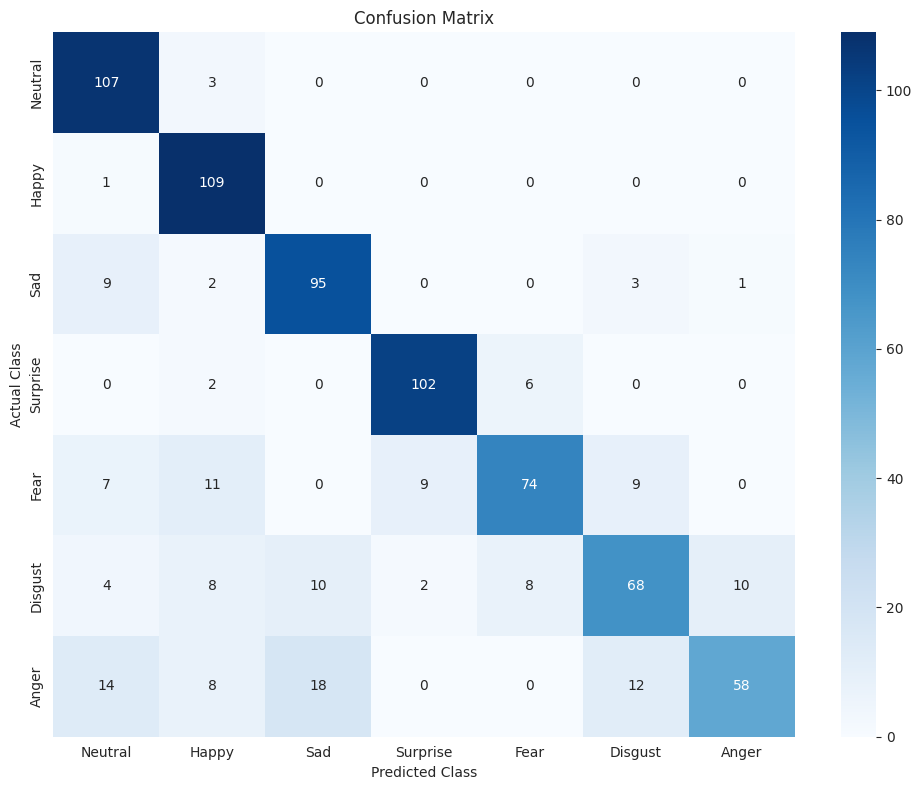

In [17]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


def plot_confusion_matrix(y_true, y_pred):
    class_names = id_to_emotion.values()

    cm = confusion_matrix(y_true, y_pred)
    print(cm)

    fig = plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Class')
    plt.ylabel('Actual Class')
    plt.tight_layout()
    plt.show()

    return fig


val_cm = plot_confusion_matrix(y_true_val, y_pred_val)

## Evaluate Model

In [18]:
test_loss, test_acc = combined_model.evaluate(test_dataset)
print(f"Test accuracy of combined model : {test_acc}")

24/24 [==============================] - 1s 22ms/step - loss: 0.7554 - accuracy: 0.7646
Test accuracy of combined model : 0.7645502686500549


In [19]:
y_pred_vectors = combined_model.predict(test_dataset)
y_pred = np.argmax(y_pred_vectors, axis=1)
y_true = np.concatenate([y for _, y in test_dataset], axis=0)

report = classification_report(y_true, y_pred, target_names=id_to_emotion.values(), digits=4)
print(report)

24/24 [==============================] - 0s 20ms/step
              precision    recall  f1-score   support

     Neutral     0.8273    0.8426    0.8349       108
       Happy     0.7647    0.9630    0.8525       108
         Sad     0.9059    0.7130    0.7979       108
    Surprise     0.8750    0.8426    0.8585       108
        Fear     0.7895    0.6944    0.7389       108
     Disgust     0.6032    0.7037    0.6496       108
       Anger     0.6400    0.5926    0.6154       108

    accuracy                         0.7646       756
   macro avg     0.7722    0.7646    0.7639       756
weighted avg     0.7722    0.7646    0.7639       756



[[ 91   4   3   0   0   3   7]
 [  0 104   0   0   1   0   3]
 [ 10   0  77   0   1   0  20]
 [  0   0   1  91  14   1   1]
 [  4   8   0   9  75  12   0]
 [  0  19   3   3   2  76   5]
 [  5   1   1   1   2  34  64]]


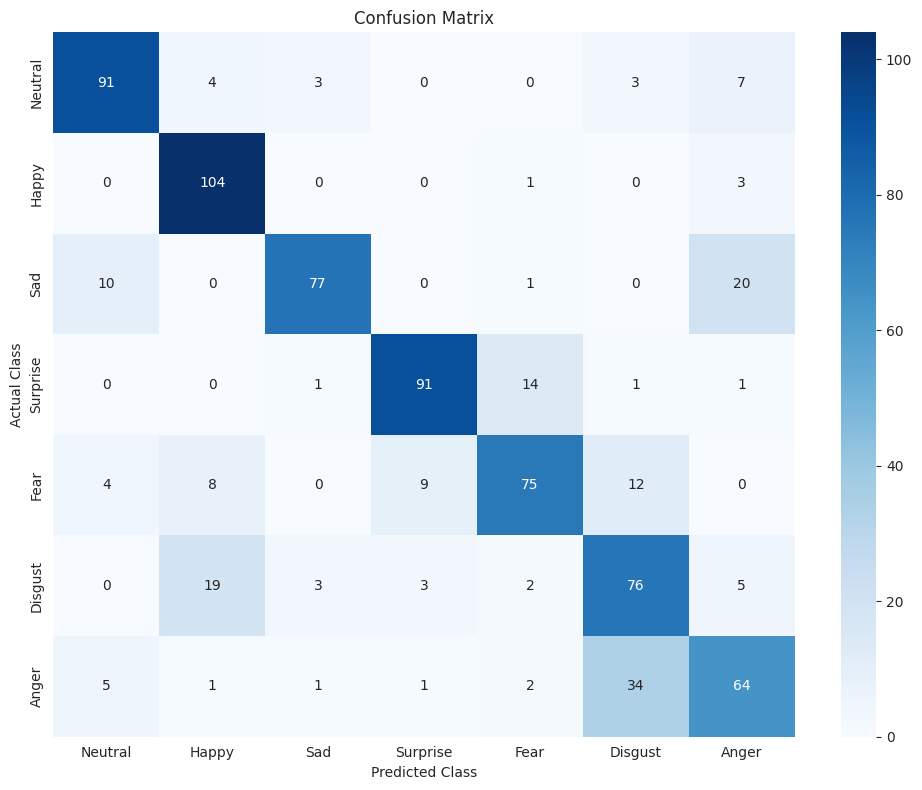

In [20]:
cm_figure = plot_confusion_matrix(y_true, y_pred)

In [21]:
def save_evaluation_results(report, cm_figure, checkpoint_dir):
    with (checkpoint_dir / 'classification_report.txt').open(mode='w') as f:
        f.write(report)
    cm_figure.savefig(str(checkpoint_dir / 'confusion_matrix.png'))


save_evaluation_results(report, cm_figure, checkpoint_dir)

In [22]:
import time

time.sleep(3)

In [23]:
import shutil

shutil.copy2((Path() / name_of_this_notebook), (checkpoint_dir / name_of_this_notebook))

PosixPath('20241218-1632-checkpoint-batch-32-lr-1e-03-AVERAGE/late_fusion_average.ipynb')